In [1]:
# 07/01/2021 Luís

# In this notebook, the Ogden model can be applied for a uniaxial or for a equibiaxial load.

# For the equibiaxial load the function now returns [T[0,0], T[1,1]] (T is the Cauchy Stress Tensor)

# The function has been modified to compute the eigenvalues of F, so it could be
# more easily adapted for more complex F tensors.

# We will still only consider N = 3 for now.
# Still need to change α and μ generation to include negative values

# ON GOING:
# I am doing some research on the HGO model.
# I'm also trying to figure out how to implement variable values for N (N = 1, 2 or 3).

In [2]:
import pandas as pd
import random
import sympy as sym
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [3]:
def ogden(params, stretch, load):
    #returns cauchy stress at yy direction

    if load != 'uniaxial' and load != 'equibiaxial':
        raise ValueError("Load string isn't acceptable")
    
    #3x3 Identity Matrix
    I = sym.Matrix([[1,0,0],[0,1,0],[0,0,1]])

    #Symbolic Principal stretches.
    λ1 = sym.Symbol('λ1')
    λ2 = sym.Symbol('λ2')
    λ3 = sym.Symbol('λ3')
    
    #Symbolic Ogden Parameters
    
    #'α_k'
    α1 = sym.Symbol('α1')
    α2 = sym.Symbol('α2')
    α3 = sym.Symbol('α3')
    α = sym.Matrix([α1,α2,α3])
    
    #"μ_k"
    μ1 = sym.Symbol('μ1')
    μ2 = sym.Symbol('μ2')
    μ3 = sym.Symbol('μ3')
    μ = sym.Matrix([μ1,μ2,μ3])

    #Generate SEF (Strain Energy Function)
 
    
    sef = 0
    for i in range(3):
        sef = sef + 2*(μ[i]/α[i]**2) * (λ1**α[i] + λ2**α[i] + λ3**α[i] - 3)
    
    #Second Piola Kirchoff Stresses 

    S1=(1/λ1)*sym.diff(sef,λ1)
    S2=(1/λ2)*sym.diff(sef,λ2)
    S3=(1/λ3)*sym.diff(sef,λ3)
    S = sym.Matrix([[S1,0,0], [0,S2,0], [0,0,S3]]) 
    
    # The values of λi will be computed for the particular F tensor.
    
    # Deformation Gradient F
    F11 = sym.Symbol('F11')
    F12 = sym.Symbol('F12')
    F13 = sym.Symbol('F13')
    F21 = sym.Symbol('F21')
    F22 = sym.Symbol('F22')
    F23 = sym.Symbol('F23')
    F31 = sym.Symbol('F31')
    F32 = sym.Symbol('F32')
    F33 = sym.Symbol('F33')
    F = sym.Matrix([[F11,F12,F13], [F21,F22,F23], [F31,F32,F33]])
    
    if load == 'uniaxial':
        F = F.subs([(F11, 1/sym.sqrt(stretch)), (F12, 0), 
                                  (F13, 0),(F21, 0), 
                                  (F22, stretch), (F23, 0),
                                  (F31, 0), (F32, 0), 
                                  (F33, 1/sym.sqrt(stretch))])
        
    if load == 'equibiaxial':
        F = F.subs([(F11, stretch), (F12, 0), 
                                (F13, 0),(F21, 0), 
                                (F22, stretch), (F23, 0),
                                (F31, 0), (F32, 0), 
                                (F33, 1/(stretch**2))])

    # Eigenvectors and Eigenvalues
    [Qt, F_diag] = F.diagonalize()
    
    F_princ = sym.zeros(3)
    
    # Put λ1, λ2, λ3 in the right order
    λ1v= np.max(F_diag)
    F_diag[np.argmax(F_diag)] = 0
    F_princ[0,0] = λ1v
    
    λ2v= np.max(F_diag)
    F_diag[np.argmax(F_diag)] = 0
    F_princ[1,1] = λ2v
    
    λ3v= np.max(F_diag)
    F_princ[2,2] = λ3v
    
    T=(F_princ*S*F_princ)
    
    # Boundary Conditions
    T = T - (I*T[2,2])

    T = T.subs([(α1, params[0]), (α2, params[1]), (α3, params[2]), (μ1, params[3]), (μ2, params[4]), 
                                  (μ3,params[5]), (λ1, λ1v), (λ2, λ2v), (λ3, λ3v)])
    
    if load == 'uniaxial':
        return stretch, T[0,0]

    if load == 'equibiaxial':
        return stretch, [T[0,0],T[1,1]]
                         
    

def get_curve(params,stretch_min,stretch_max,ninc, load):
    #stores Ogden runs between minimum and a maximum stretch
    lst=[ogden(params, stretch, load) for stretch in np.linspace(stretch_min,stretch_max,ninc)]
    return lst

In [4]:
# I've done some tests and it seems to be in conformity with literature.
# I can't subtitute with symbolic values like I did in other notebooks because,
# as I compute the eigenvalues in this case, the code can't correctly identify
# the max and min values of [λ1, λ2, λ3] if they are symbols.
# Numerically, it seems to work just fine.

# For more complex F tensors I would have to compute the eigenvectors
# to determine the principal directions.

In [5]:
#Initial data-----------------------------------------------------------------------------------------------------

load = 'equibiaxial'  # loading mode

amin=0.1     #min α_k value
amax=10.0    #max α_k value
umin=0.1     #min μ_k value
umax=3.0     #max μ_k value
decimals=2   #number of decimal cases of α_k and μ_k variables

n_a=5               #number of α vectors
n_u=5              #number of μ vectors
n = n_a * n_u      #number of combinations of vectors
#
st_max=3.0            #applied stretch
st_min=1.0
ninc=20        #number of stretch increments
#------------------------------------------------------------------------------------------------------------------

In [6]:
# Generates random values for α and μ vectors
a_list = np.round(np.random.uniform(amin, amax, size=(n_a, 3)), decimals)
u_list = np.round(np.random.uniform(umin, umax, size=(n_u, 3)), decimals)

In [7]:
# Computes the n combinations of α and μ vectors

params = np.array([])

for i in a_list:
    for j in u_list:
        for k in range(3):
            params = np.append(params, np.array([i[k],j[k]]))
params = params.reshape(-1, 6)
params

array([[3.79, 0.24, 5.84, 2.91, 8.18, 2.  ],
       [3.79, 0.9 , 5.84, 0.58, 8.18, 2.78],
       [3.79, 0.59, 5.84, 1.27, 8.18, 1.01],
       [3.79, 0.45, 5.84, 1.69, 8.18, 0.88],
       [3.79, 1.44, 5.84, 2.41, 8.18, 0.76],
       [1.28, 0.24, 8.51, 2.91, 6.01, 2.  ],
       [1.28, 0.9 , 8.51, 0.58, 6.01, 2.78],
       [1.28, 0.59, 8.51, 1.27, 6.01, 1.01],
       [1.28, 0.45, 8.51, 1.69, 6.01, 0.88],
       [1.28, 1.44, 8.51, 2.41, 6.01, 0.76],
       [8.26, 0.24, 8.  , 2.91, 7.66, 2.  ],
       [8.26, 0.9 , 8.  , 0.58, 7.66, 2.78],
       [8.26, 0.59, 8.  , 1.27, 7.66, 1.01],
       [8.26, 0.45, 8.  , 1.69, 7.66, 0.88],
       [8.26, 1.44, 8.  , 2.41, 7.66, 0.76],
       [4.7 , 0.24, 4.  , 2.91, 3.87, 2.  ],
       [4.7 , 0.9 , 4.  , 0.58, 3.87, 2.78],
       [4.7 , 0.59, 4.  , 1.27, 3.87, 1.01],
       [4.7 , 0.45, 4.  , 1.69, 3.87, 0.88],
       [4.7 , 1.44, 4.  , 2.41, 3.87, 0.76],
       [9.67, 0.24, 3.69, 2.91, 1.64, 2.  ],
       [9.67, 0.9 , 3.69, 0.58, 1.64, 2.78],
       [9.

In [8]:
# Append the combinations to a DataFrame

df = pd.DataFrame(params[:,0], columns = ['a1'])
df['a2'] = params[:,1]
df['a3'] = params[:,2]
df['u1'] = params[:,3]
df['u2'] = params[:,4]
df['u3'] = params[:,5]

df

# Later I will deal with duplicates

,a1,a2,a3,u1,u2,u3
0,3.79,0.24,5.84,2.91,8.18,2.00
1,3.79,0.90,5.84,0.58,8.18,2.78
2,3.79,0.59,5.84,1.27,8.18,1.01
3,3.79,0.45,5.84,1.69,8.18,0.88
4,3.79,1.44,5.84,2.41,8.18,0.76
5,1.28,0.24,8.51,2.91,6.01,2.00
6,1.28,0.90,8.51,0.58,6.01,2.78
7,1.28,0.59,8.51,1.27,6.01,1.01
8,1.28,0.45,8.51,1.69,6.01,0.88
9,1.28,1.44,8.51,2.41,6.01,0.76


In [9]:
#generate (x,y) data for each unique combination of params at the dataframe
df['data']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc, load), axis=1)
df

,a1,a2,a3,u1,u2,u3,data
0,3.79,0.24,5.84,2.91,8.18,2.00,"[(1.0, [0, 0]), (1.1052631578947367, [7.395360..."
1,3.79,0.90,5.84,0.58,8.18,2.78,"[(1.0, [0, 0]), (1.1052631578947367, [6.426259..."
2,3.79,0.59,5.84,1.27,8.18,1.01,"[(1.0, [0, 0]), (1.1052631578947367, [5.953994..."
3,3.79,0.45,5.84,1.69,8.18,0.88,"[(1.0, [0, 0]), (1.1052631578947367, [6.138978..."
4,3.79,1.44,5.84,2.41,8.18,0.76,"[(1.0, [0, 0]), (1.1052631578947367, [6.255191..."
5,1.28,0.24,8.51,2.91,6.01,2.00,"[(1.0, [0, 0]), (1.1052631578947367, [6.231862..."
6,1.28,0.90,8.51,0.58,6.01,2.78,"[(1.0, [0, 0]), (1.1052631578947367, [5.201549..."
7,1.28,0.59,8.51,1.27,6.01,1.01,"[(1.0, [0, 0]), (1.1052631578947367, [4.741416..."
8,1.28,0.45,8.51,1.69,6.01,0.88,"[(1.0, [0, 0]), (1.1052631578947367, [4.936131..."
9,1.28,1.44,8.51,2.41,6.01,0.76,"[(1.0, [0, 0]), (1.1052631578947367, [5.136183..."


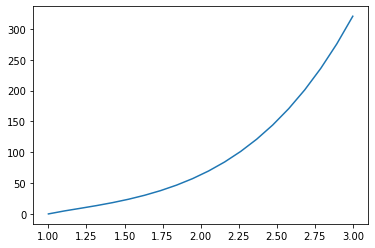

In [24]:
k = 15 # plot curve number k

example = np.array(df.data[k],dtype = object)
stress = example[:, 1]
stress_xx = np.array([])
for i in stress: stress_xx = np.append(stress_xx,i[0])

stretch = example[:, 0]
y = stress_xx
plt.plot(stretch,y)